#📌 Extracción

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
print("--- Paso 1: Extracción de Datos ---")
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'
try:
    response = requests.get(url)
    response.raise_for_status() # Lanza un error para códigos de estado HTTP erróneos
    data = response.json()
    print("Datos extraídos correctamente.")
except requests.exceptions.RequestException as e:
    print(f"Error al extraer los datos de la URL: {e}")
    # Considera una lógica para cargar un archivo local si la URL falla
    try:
        # Esto es solo un ejemplo, descomenta si tienes el archivo localmente
        # data = pd.read_json('/content/TelecomX_Data.json').to_dict(orient='records')
        # print("Cargando desde archivo local como respaldo.")
        pass
    except FileNotFoundError:
        print("El archivo local tampoco se encontró. Terminando el script.")
        exit() # Termina la ejecución si no se pueden cargar los datos


--- Paso 1: Extracción de Datos ---
Datos extraídos correctamente.


#🔧 Transformación

Funciones comunes para transformacion de datos

df.isnull().sum          verifica los nulos de cada columna
df.duplicated().sum()    identifica registros duplicados
df.drop.duplicated()     elimina registros duplicados
df.fillna(valor)         rellena valores nulos con valor especifico
df.replace()             reemplaza valores especificos por otros
df.astype()              convierte el tipo de dato de una columna
df['Nueva_Columna']

##   Normalización de Datos

In [3]:
print("\n--- Paso 2: Normalización de Datos ---")
# Normaliza el JSON anidado en un DataFrame plano
df_telecom_normalizado = pd.json_normalize(data)

print(f"DataFrame normalizado creado con {df_telecom_normalizado.shape[0]} filas y {df_telecom_normalizado.shape[1]} columnas.")
print("Primeras 5 filas del DataFrame normalizado:")
print(df_telecom_normalizado.head())
print("\nInformación del DataFrame normalizado:")
df_telecom_normalizado.info()


--- Paso 2: Normalización de Datos ---
DataFrame normalizado creado con 7267 filas y 21 columnas.
Primeras 5 filas del DataFrame normalizado:
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13              

In [4]:
df_telecom_normalizado.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


In [5]:
# Normalizar y renombrar columnas con prefijo
#df_customer = pd.json_normalize(df_telecom['customer'])
#df_customer.columns = [f"customer.{col}" for col in df_customer.columns]

#df_phone = pd.json_normalize(df_telecom['phone'])
#df_phone.columns = [f"phone.{col}" for col in df_phone.columns]

#df_internet = pd.json_normalize(df_telecom['internet'])
#df_internet.columns = [f"internet.{col}" for col in df_internet.columns]

#df_account = pd.json_normalize(df_telecom['account'])
#df_account.columns = [f"account.{col}" for col in df_account.columns]

# Combinar todo
#df_telecom_normalizado = pd.concat([
    #df_telecom[['customerID', 'Churn']],
    #df_customer,
    #df_phone,
    #df_internet,
    #df_account
#], axis=1)

## Limpieza de datos

In [6]:
print("\n--- Paso 3: Limpieza de Datos ---")

# Verificar si hay duplicados
duplicados = df_telecom_normalizado.duplicated().sum()
print(f"\nNúmero de líneas duplicadas antes de eliminar: {duplicados}")
if duplicados > 0:
    df_telecom_normalizado.drop_duplicates(inplace=True)
    print(f"Se eliminaron {duplicados} filas duplicadas. Nuevo tamaño: {df_telecom_normalizado.shape}")
else:
    print("No se encontraron filas duplicadas.")


--- Paso 3: Limpieza de Datos ---

Número de líneas duplicadas antes de eliminar: 0
No se encontraron filas duplicadas.


In [7]:
# 3.1 Manejo de 'account.Charges.Total'
# Convertir a numérico, forzando errores a NaN
df_telecom_normalizado['account.Charges.Total'] = pd.to_numeric(
    df_telecom_normalizado['account.Charges.Total'], errors='coerce'
)

In [8]:
# Identificar filas donde 'account.Charges.Total' se convirtió en NaN (eran espacios en blanco o no numéricos)
filas_con_cargos_nulos = df_telecom_normalizado[df_telecom_normalizado['account.Charges.Total'].isna()]
print(f"\nFilas con 'account.Charges.Total' nulo o no numérico antes de rellenar: {len(filas_con_cargos_nulos)}")
if not filas_con_cargos_nulos.empty:
    print("Ejemplo de estas filas:")
    print(filas_con_cargos_nulos[['customerID', 'account.Charges.Total', 'customer.tenure']].head())


Filas con 'account.Charges.Total' nulo o no numérico antes de rellenar: 11
Ejemplo de estas filas:
      customerID  account.Charges.Total  customer.tenure
975   1371-DWPAZ                    NaN                0
1775  2520-SGTTA                    NaN                0
1955  2775-SEFEE                    NaN                0
2075  2923-ARZLG                    NaN                0
2232  3115-CZMZD                    NaN                0


In [9]:
# Reemplazar NaN con 0 y convertir a float64
df_telecom_normalizado['account.Charges.Total'] = df_telecom_normalizado['account.Charges.Total'].fillna(0).astype(np.float64)
print("'account.Charges.Total' rellenado con 0 y convertido a float64.")


'account.Charges.Total' rellenado con 0 y convertido a float64.


In [10]:
# 3.2 Manejo de la columna 'Churn' (limpieza de espacios en blanco)
# Identificar filas donde 'Churn' es una cadena vacía o solo espacios
filas_churn_vacio = df_telecom_normalizado[df_telecom_normalizado['Churn'].astype(str).str.strip() == '']
print(f"\nFilas con 'Churn' vacío antes de eliminar: {len(filas_churn_vacio)}")
if not filas_churn_vacio.empty:
    print("Ejemplo de estas filas:")
    print(filas_churn_vacio[['customerID', 'Churn']].head())
    df_telecom_normalizado = df_telecom_normalizado[
        df_telecom_normalizado['Churn'].astype(str).str.strip() != ''
    ].copy() # Usar .copy() para evitar SettingWithCopyWarning
    print(f"Se eliminaron {len(filas_churn_vacio)} filas con 'Churn' vacío. Nuevo tamaño: {df_telecom_normalizado.shape}")
else:
    print("No se encontraron filas con 'Churn' vacío.")


Filas con 'Churn' vacío antes de eliminar: 224
Ejemplo de estas filas:
     customerID Churn
30   0047-ZHDTW      
75   0120-YZLQA      
96   0154-QYHJU      
98   0162-RZGMZ      
175  0274-VVQOQ      
Se eliminaron 224 filas con 'Churn' vacío. Nuevo tamaño: (7043, 21)


In [11]:
# 3.3 Verificación final de nulos y vacíos
print("\nVerificación final de valores nulos y strings vacíos:")
print("\nValores nulos por columna (después de limpieza):")
nulos_final = df_telecom_normalizado.isnull().sum()
print(nulos_final[nulos_final > 0]) # Solo muestra columnas con nulos

print('\nValores en blanco o strings vacíos por columna (después de limpieza):')
vacios_final = df_telecom_normalizado.apply(lambda x: x.astype(str).str.strip() == '').sum()
print(vacios_final[vacios_final > 0]) # Solo muestra columnas con vacíos

print("\n--- Limpieza de Datos Completada ---")


Verificación final de valores nulos y strings vacíos:

Valores nulos por columna (después de limpieza):
Series([], dtype: int64)

Valores en blanco o strings vacíos por columna (después de limpieza):
Series([], dtype: int64)

--- Limpieza de Datos Completada ---


In [12]:
# --- 4. Ajustes de Tipos de Datos ---
print("\n--- Paso 4: Ajustes de Tipos de Datos ---")
# Ejemplo: Convertir 'customer.SeniorCitizen' a tipo booleano o categórico si es necesario
# Si '0' y '1' son las únicas opciones, se puede tratar como bool o category
df_telecom_normalizado['customer.SeniorCitizen'] = df_telecom_normalizado['customer.SeniorCitizen'].astype(bool)
# O si prefieres mantener como números pero indicando que es categoría:
# df_telecom_normalizado['customer.SeniorCitizen'] = df_telecom_normalizado['customer.SeniorCitizen'].astype('category')

# Convertir la columna 'Churn' a tipo categórico para optimizar memoria y para modelos
df_telecom_normalizado['Churn'] = df_telecom_normalizado['Churn'].astype('category')
# También puedes mapear 'Yes'/'No' a 1/0 para modelos de ML
df_telecom_normalizado['Churn_Numeric'] = df_telecom_normalizado['Churn'].map({'Yes': 1, 'No': 0})
print("Tipos de datos ajustados para 'customer.SeniorCitizen' y 'Churn'.")
print("\nInformación del DataFrame después de ajustes de tipos:")
df_telecom_normalizado.info()


--- Paso 4: Ajustes de Tipos de Datos ---
Tipos de datos ajustados para 'customer.SeniorCitizen' y 'Churn'.

Información del DataFrame después de ajustes de tipos:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7043 non-null   object  
 1   Churn                      7043 non-null   category
 2   customer.gender            7043 non-null   object  
 3   customer.SeniorCitizen     7043 non-null   bool    
 4   customer.Partner           7043 non-null   object  
 5   customer.Dependents        7043 non-null   object  
 6   customer.tenure            7043 non-null   int64   
 7   phone.PhoneService         7043 non-null   object  
 8   phone.MultipleLines        7043 non-null   object  
 9   internet.InternetService   7043 non-null   object  
 10  internet.OnlineSecurity    7043 non-null   o

In [13]:
df_telecom_normalizado.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Churn_Numeric
0,0002-ORFBO,No,Female,False,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0
1,0003-MKNFE,No,Male,False,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0
2,0004-TLHLJ,Yes,Male,False,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1
3,0011-IGKFF,Yes,Male,True,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1
4,0013-EXCHZ,Yes,Female,True,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1


In [14]:
#Verificar si hay valores unicos en las columnas
for col in df_telecom_normalizado.columns:
    print(f"Valores únicos en la columna'{col}': {df_telecom_normalizado[col].nunique()}")
    if df_telecom_normalizado[col].nunique() < 50: #imprime los valores solamente si no hay muchos
        print(df_telecom_normalizado[col].unique())
        print('-' * 50)# Linea divisoria para mejor visualización


Valores únicos en la columna'customerID': 7043
Valores únicos en la columna'Churn': 2
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
--------------------------------------------------
Valores únicos en la columna'customer.gender': 2
['Female' 'Male']
--------------------------------------------------
Valores únicos en la columna'customer.SeniorCitizen': 2
[False  True]
--------------------------------------------------
Valores únicos en la columna'customer.Partner': 2
['Yes' 'No']
--------------------------------------------------
Valores únicos en la columna'customer.Dependents': 2
['Yes' 'No']
--------------------------------------------------
Valores únicos en la columna'customer.tenure': 73
Valores únicos en la columna'phone.PhoneService': 2
['Yes' 'No']
--------------------------------------------------
Valores únicos en la columna'phone.MultipleLines': 3
['No' 'Yes' 'No phone service']
--------------------------------------------------
Valores únicos en la columna'internet.I

In [15]:
#verificamos que no hay mas filas vacias
valores_en_blanco_o_vacio = df_telecom_normalizado.apply(lambda x: x.astype(str).str.strip() == '').sum()
print('\nValores en blanco o string vacios por columna:')
print(valores_en_blanco_o_vacio[valores_en_blanco_o_vacio > 0])


Valores en blanco o string vacios por columna:
Series([], dtype: int64)


# Variables más relevantes para predecir la evasión

| Categoría       | Variables clave                                    | Por qué                                                                 |
| --------------- | -------------------------------------------------- | ----------------------------------------------------------------------- |
| 📊 **Finanzas** | `account.tenure`,`Charges.Montly`,`Charges.Total` | Clientes con poco tiempo o cargos altos suelen irse más.                |
| 🌐 **Internet** | `InternetService`,`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`,`TechSupport`, `StreamingTV`, `StreamingMovies`  | Uso bajo o sin servicios adicionales puede indicar baja satisfacción.   |
| 📞 **Teléfono** | `PhoneService`, `MultipleLines`                  | Puede estar vinculado a la calidad del servicio                         |
| 👤 **Cliente**  | `Partner`, `SeniorCitizen`, `dependents`,`senior`          | Perfil demográfico influye en la lealtad.                               |
| 💳 **Pagos**    | `PaymentMethod`,`Contract`| Algunas formas de pago están relacionadas con tasas de churn más altas. |


## Variables que considero más relevantes para el churn

**Churn**: Esta es nuestra variable objetivo, la que queremos predecir. Es categórica (Yes/No).

**customer.tenure**: Antigüedad del cliente.

**account.Contract**: Tipo de contrato del cliente.

**account.Charges.Monthly**: Cargo mensual.

**internet.InternetService**: Tipo de servicio de internet.

**internet.TechSupport**: Si el cliente tiene soporte técnico.

**account.PaymentMethod**: Método de pago.

**account.PaperlessBilling**: Facturación sin papel.

**customer.Partner / customer.Dependents**: Si el cliente tiene pareja o dependientes.

## 📊 Carga y análisis

In [16]:
df_telecom_normalizado.describe().T


,count,mean,std,min,25%,50%,75%,max
customer.tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
account.Charges.Monthly,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
account.Charges.Total,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


## Churn (Variable Objetivo)
**Explicación**: Es la variable que queremos predecir. Un cliente "Yes" (abandona) o "No" (no abandona). Es crucial entender su distribución.

**Tipo de Dato**: Categórico (ya la convertimos a category y creamos una versión numérica Churn_Numeric para modelos).

**Tratamiento**: No requiere transformación adicional para el análisis exploratorio, pero para Machine Learning, la codificación numérica (Yes=1, No=0) es estándar.

**Gráfico**: Un simple conteo para ver el balance de clases.


--- Análisis de la Variable Objetivo: Churn ---
Distribución de Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Porcentaje de Churn: 26.54%


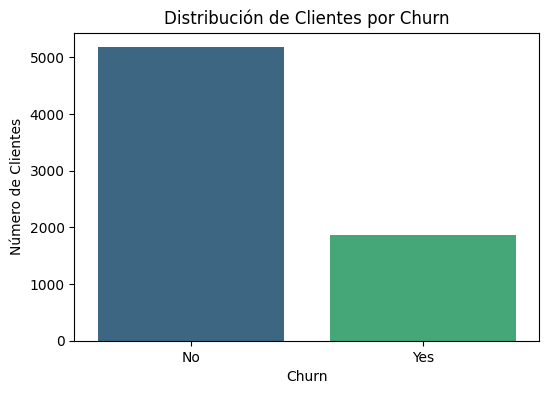

In [17]:
print("\n--- Análisis de la Variable Objetivo: Churn ---")
# Conteo de clientes con y sin churn
churn_counts = df_telecom_normalizado['Churn'].value_counts()
print("Distribución de Churn:")
print(churn_counts)
print(f"Porcentaje de Churn: {churn_counts.get('Yes', 0) / len(df_telecom_normalizado) * 100:.2f}%")


# Gráfico de barras (CORREGIDO para evitar la FutureWarning)
plt.figure(figsize=(6, 4))
sns.countplot(data=df_telecom_normalizado, x='Churn', hue='Churn', palette='viridis', legend=False)
plt.title('Distribución de Clientes por Churn')
plt.xlabel('Churn')
plt.ylabel('Número de Clientes')
plt.show()

# Gráfico de torta (pie chart) para porcentajes
fig = px.pie(df_telecom_normalizado, names='Churn', title='Proporción de Clientes con y sin Churn',
             color_discrete_sequence=px.colors.sequential.Viridis, hole=0.3) # hole=0.3 para un donut chart
fig.show()

## customer.tenure (Antigüedad del cliente)
**Explicación**: Representa el número de meses que el cliente ha estado con la empresa. Es un indicador clave del compromiso y la lealtad. Generalmente, a mayor antigüedad, menor probabilidad de churn.

**Tipo de Dato**: Numérico (entero).

**Tratamiento**:

**Verificar su distribución.**

Puede ser útil categorizarla en rangos para análisis de grupos, o dejarla como numérica para modelos.

**Gráficos**:

**Histograma para ver la distribución.**

Boxplot de tenure vs Churn para ver si hay diferencias en la antigüedad promedio entre clientes que se van y los que se quedan.

Gráfico de líneas de la tasa de churn a lo largo del tiempo.


--- Análisis de customer.tenure ---
Estadísticas descriptivas de customer.tenure:
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: customer.tenure, dtype: float64


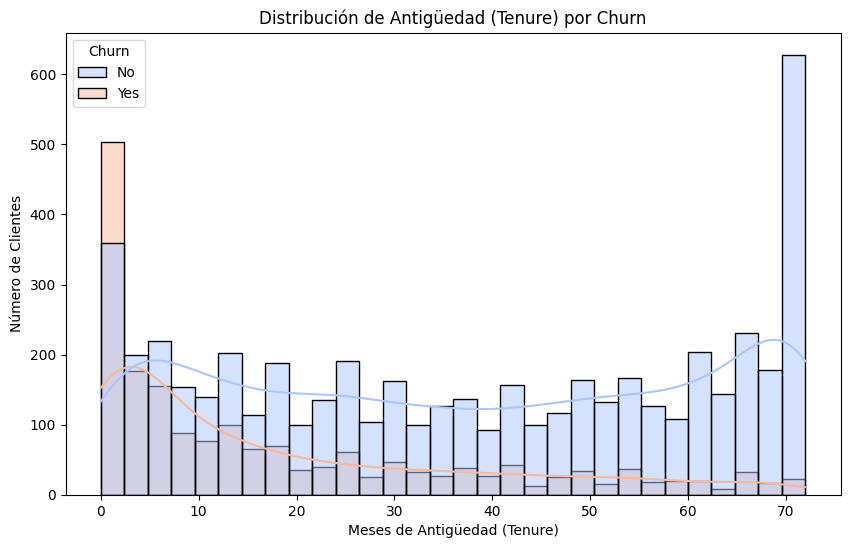

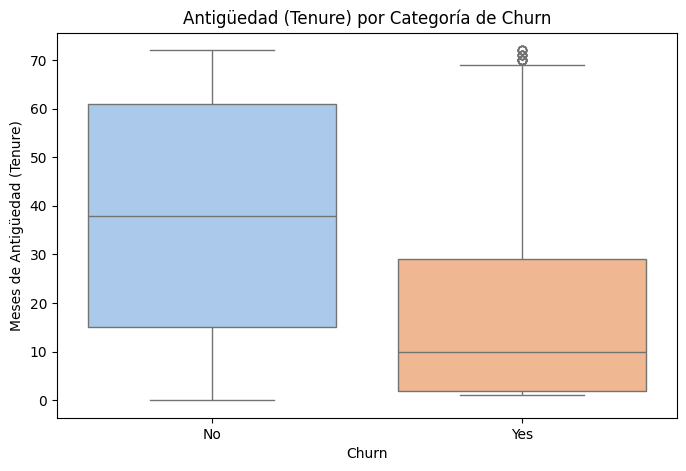

In [18]:
print("\n--- Análisis de customer.tenure ---")
print("Estadísticas descriptivas de customer.tenure:")
print(df_telecom_normalizado['customer.tenure'].describe())

# Histograma de tenure
plt.figure(figsize=(10, 6))
sns.histplot(data=df_telecom_normalizado, x='customer.tenure', bins=30, kde=True, hue='Churn', palette='coolwarm')
plt.title('Distribución de Antigüedad (Tenure) por Churn')
plt.xlabel('Meses de Antigüedad (Tenure)')
plt.ylabel('Número de Clientes')
plt.show()

# Boxplot de tenure vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_telecom_normalizado, x='Churn', hue='Churn', y='customer.tenure', palette='pastel', legend=False)
plt.title('Antigüedad (Tenure) por Categoría de Churn')
plt.xlabel('Churn')
plt.ylabel('Meses de Antigüedad (Tenure)')
plt.show()

# Convert 'Yes'/'No' Churn to numeric for calculation
df_telecom_normalizado['Churn_Numeric'] = df_telecom_normalizado['Churn'].apply(lambda x: 1 if x == 'Yes' else 0).astype('int64')

# Tasa de Churn por Tenure (reafirmando tu buen trabajo)
df_grouped_tenure = df_telecom_normalizado.groupby('customer.tenure')['Churn_Numeric'].mean().reset_index()
df_grouped_tenure['churn_rate_percent'] = df_grouped_tenure['Churn_Numeric'] * 100

fig = px.line(df_grouped_tenure,
              x='customer.tenure',
              y='churn_rate_percent',
              markers=True,
              title='Tasa de Churn (%) por Antigüedad del Cliente (Tenure)',
              labels={'customer.tenure': 'Meses de Antigüedad', 'churn_rate_percent': 'Tasa de Churn (%)'})
fig.update_traces(line_color='red')
fig.show()

## account.Contract (Tipo de Contrato)
**Explicación**: Un predictor extremadamente fuerte. Los clientes con contratos mensuales tienen mucha más libertad para irse sin penalización que aquellos con contratos a largo plazo (1 o 2 años).

**Tipo de Dato**: Categórico.

**Tratamiento**: Codificación One-Hot Encoding para modelos de Machine Learning (crea nuevas columnas binarias para cada categoría).

**Gráfico**: Barras con hue='Churn' para ver la distribución del churn dentro de cada tipo de contrato.


--- Análisis de account.Contract ---
Distribución de tipos de contrato:
account.Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


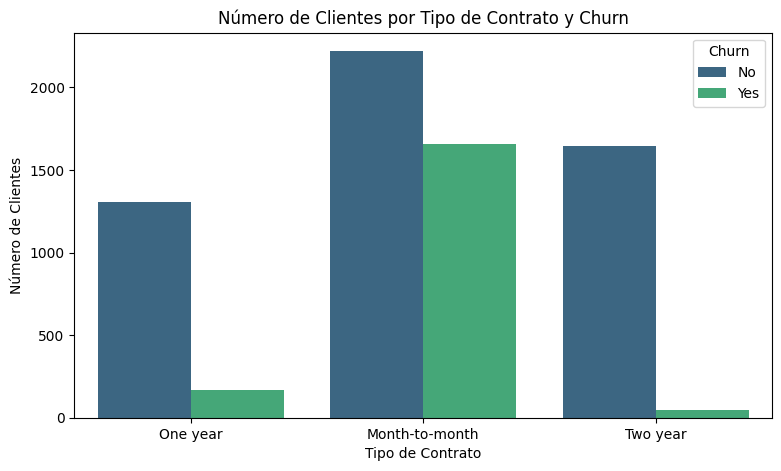


Porcentaje de Churn por Tipo de Contrato:
Churn                No    Yes
account.Contract              
Month-to-month    57.29  42.71
One year          88.73  11.27
Two year          97.17   2.83


In [19]:
print("\n--- Análisis de account.Contract ---")
print("Distribución de tipos de contrato:")
print(df_telecom_normalizado['account.Contract'].value_counts())

plt.figure(figsize=(9, 5))
sns.countplot(data=df_telecom_normalizado, x='account.Contract', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Tipo de Contrato y Churn')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Número de Clientes')
plt.show()

# Porcentaje de Churn por tipo de contrato
churn_contract = df_telecom_normalizado.groupby('account.Contract')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Tipo de Contrato:")
print(churn_contract.round(2))

fig = px.bar(churn_contract.reset_index(),
             x='account.Contract',
             y='Yes', # Tasa de Churn (Yes)
             title='Porcentaje de Churn por Tipo de Contrato',
             labels={'account.Contract': 'Tipo de Contrato', 'Yes': 'Porcentaje de Churn'},
             color_discrete_sequence=['red'])
fig.show()

## account.Charges.Monthly (Cargo Mensual)
**Explicación**: El monto que el cliente paga cada mes. Los cargos muy bajos pueden indicar un servicio básico (y quizás menos valor percibido), mientras que los cargos muy altos pueden generar insatisfacción si el valor no es percibido.

**Tipo de Dato**: Numérico (float).

**Tratamiento**: Escalar para modelos de Machine Learning (MinMaxScaler o StandardScaler).

**Gráficos**:

Histograma para ver la distribución.

Boxplot de Charges.Monthly vs Churn.

Dispersión con tenure coloreada por Churn (para ver la relación entre gasto, antigüedad y churn).


--- Análisis de account.Charges.Monthly ---
Estadísticas descriptivas de account.Charges.Monthly:
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: account.Charges.Monthly, dtype: float64


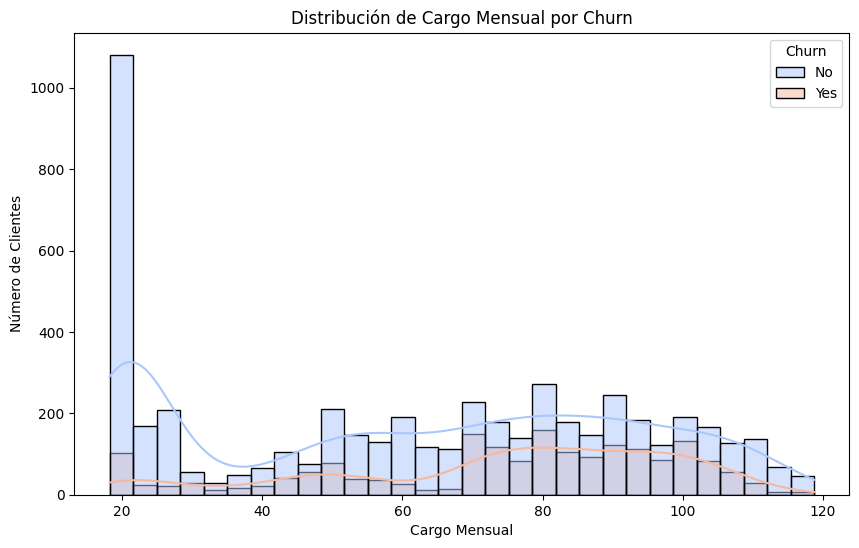

/tmp/ipython-input-20-3014971464.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




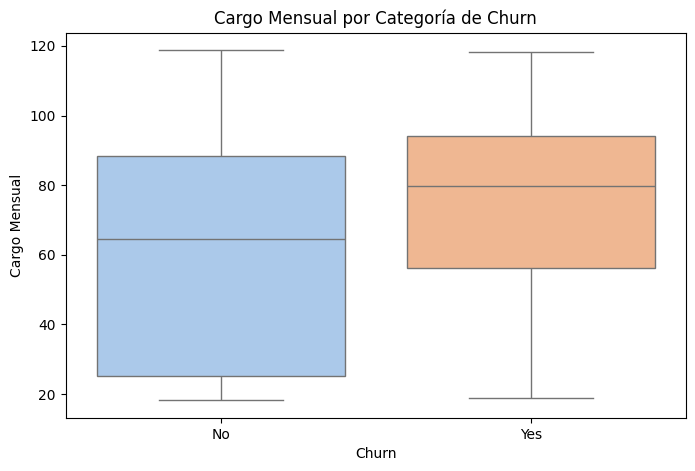

In [20]:
print("\n--- Análisis de account.Charges.Monthly ---")
print("Estadísticas descriptivas de account.Charges.Monthly:")
print(df_telecom_normalizado['account.Charges.Monthly'].describe())

# Histograma de Monthly Charges
plt.figure(figsize=(10, 6))
sns.histplot(data=df_telecom_normalizado, x='account.Charges.Monthly', bins=30, kde=True, hue='Churn', palette='coolwarm')
plt.title('Distribución de Cargo Mensual por Churn')
plt.xlabel('Cargo Mensual')
plt.ylabel('Número de Clientes')
plt.show()

# Boxplot de Monthly Charges vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_telecom_normalizado, x='Churn', y='account.Charges.Monthly', palette='pastel')
plt.title('Cargo Mensual por Categoría de Churn')
plt.xlabel('Churn')
plt.ylabel('Cargo Mensual')
plt.show()

# Scatter plot con Tenure y Monthly Charges (reafirmando tu buen trabajo)
fig = px.scatter(df_telecom_normalizado,
                 x='customer.tenure',
                 y='account.Charges.Monthly',
                 color='Churn',
                 title='Relación entre Antigüedad, Cargo Mensual y Churn',
                 labels={'customer.tenure': 'Antigüedad (Meses)', 'account.Charges.Monthly': 'Cargo Mensual'})
fig.show()

## internet.InternetService (Tipo de Servicio de Internet)
**Explicación**: Si el cliente tiene DSL, Fibra Óptica, o ningún servicio de internet. El tipo de servicio puede influir en la satisfacción. La Fibra Óptica, aunque más rápida, a veces viene con expectativas de rendimiento más altas o problemas técnicos específicos.

**Tipo de Dato**: Categórico.

**Tratamiento**: One-Hot Encoding para modelos.

**Gráfico**: Barras con hue='Churn'.


--- Análisis de internet.InternetService ---
Distribución de tipos de servicio de internet:
internet.InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


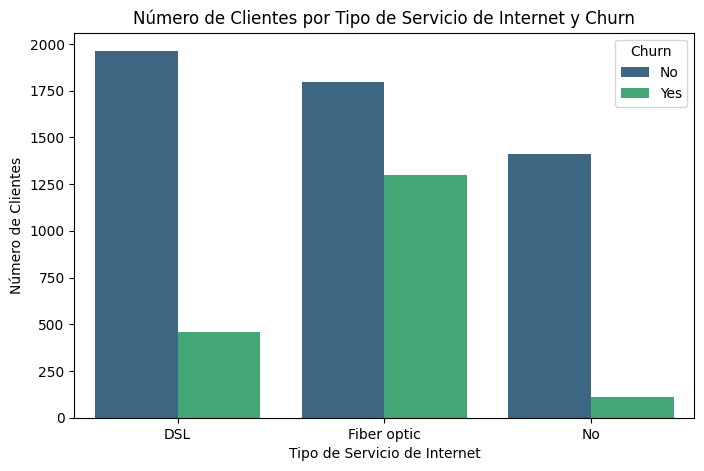


Porcentaje de Churn por Tipo de Servicio de Internet:
Churn                        No    Yes
internet.InternetService              
DSL                       81.04  18.96
Fiber optic               58.11  41.89
No                        92.60   7.40


In [21]:
print("\n--- Análisis de internet.InternetService ---")
print("Distribución de tipos de servicio de internet:")
print(df_telecom_normalizado['internet.InternetService'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df_telecom_normalizado, x='internet.InternetService', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Tipo de Servicio de Internet y Churn')
plt.xlabel('Tipo de Servicio de Internet')
plt.ylabel('Número de Clientes')
plt.show()

# Porcentaje de Churn por tipo de servicio de internet
churn_internet_service = df_telecom_normalizado.groupby('internet.InternetService')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Tipo de Servicio de Internet:")
print(churn_internet_service.round(2))

fig = px.bar(churn_internet_service.reset_index(),
             x='internet.InternetService',
             y='Yes',
             title='Porcentaje de Churn por Tipo de Servicio de Internet',
             labels={'internet.InternetService': 'Tipo de Servicio de Internet', 'Yes': 'Porcentaje de Churn'},
             color_discrete_sequence=['purple'])
fig.show()

## internet.TechSupport (Soporte Técnico)
**Explicación**: Si el cliente tiene un servicio de soporte técnico. La falta de soporte técnico puede ser una causa directa de frustración y churn si el cliente encuentra problemas.

**Tipo de Dato**: Categórico (Yes/No/No internet service).

**Tratamiento**: Codificación One-Hot Encoding.

**Gráfico**: Barras con hue='Churn'.


--- Análisis de internet.TechSupport ---
Distribución de clientes con/sin soporte técnico:
internet.TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


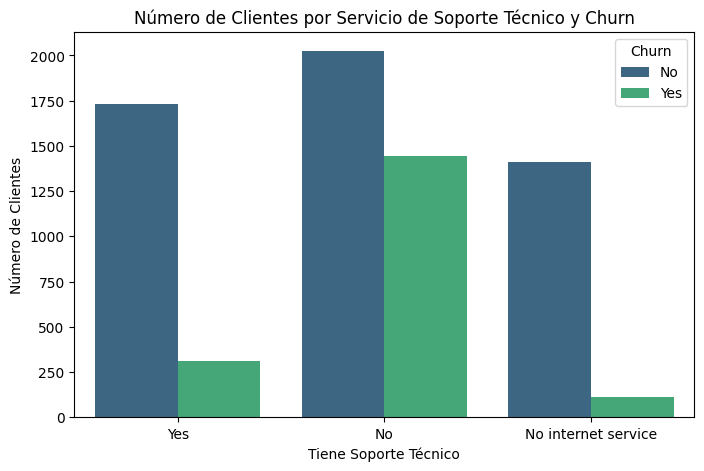


Porcentaje de Churn por Servicio de Soporte Técnico:
Churn                    No    Yes
internet.TechSupport              
No                    58.36  41.64
No internet service   92.60   7.40
Yes                   84.83  15.17


In [22]:
print("\n--- Análisis de internet.TechSupport ---")
print("Distribución de clientes con/sin soporte técnico:")
print(df_telecom_normalizado['internet.TechSupport'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df_telecom_normalizado, x='internet.TechSupport', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Servicio de Soporte Técnico y Churn')
plt.xlabel('Tiene Soporte Técnico')
plt.ylabel('Número de Clientes')
plt.show()

# Porcentaje de Churn por TechSupport
churn_tech_support = df_telecom_normalizado.groupby('internet.TechSupport')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Servicio de Soporte Técnico:")
print(churn_tech_support.round(2))

## account.PaymentMethod (Método de Pago)
**Explicación**: Cómo paga el cliente. Ciertos métodos (ej. cheque electrónico) pueden asociarse con un churn más alto, quizás porque son clientes menos "arraigados" o que prefieren transacciones más flexibles.

**Tipo de Dato**: Categórico.

**Tratamiento**: One-Hot Encoding.

**Gráfico**: Barras con hue='Churn'.


--- Análisis de account.PaymentMethod ---
Distribución de métodos de pago:
account.PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


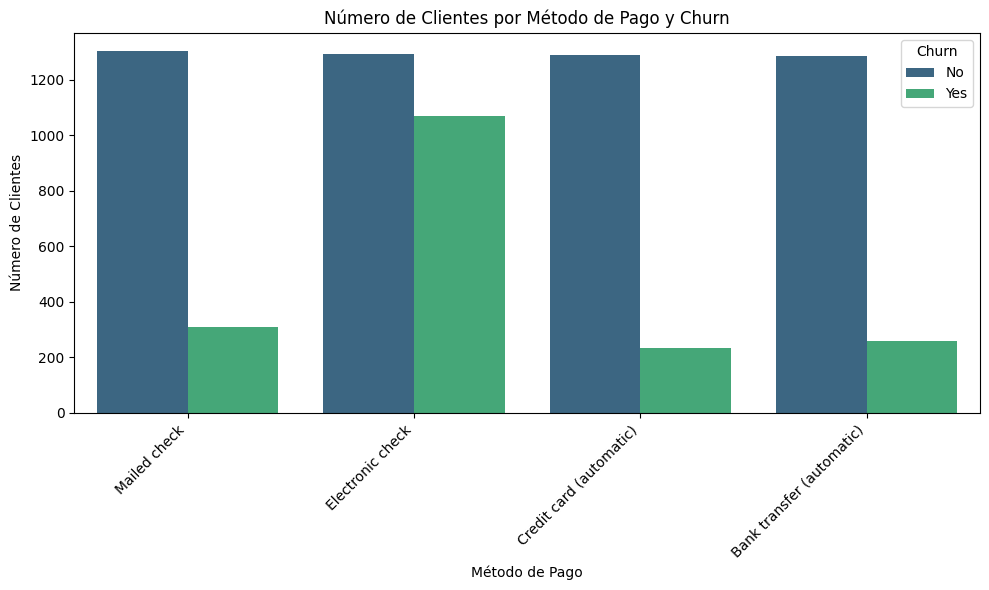


Porcentaje de Churn por Método de Pago:
Churn                         No    Yes
account.PaymentMethod                  
Bank transfer (automatic)  83.29  16.71
Credit card (automatic)    84.76  15.24
Electronic check           54.71  45.29
Mailed check               80.89  19.11


In [23]:
print("\n--- Análisis de account.PaymentMethod ---")
print("Distribución de métodos de pago:")
print(df_telecom_normalizado['account.PaymentMethod'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(data=df_telecom_normalizado, x='account.PaymentMethod', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Método de Pago y Churn')
plt.xlabel('Método de Pago')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejor visualización
plt.tight_layout() # Ajustar diseño
plt.show()

# Porcentaje de Churn por método de pago
churn_payment_method = df_telecom_normalizado.groupby('account.PaymentMethod')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Método de Pago:")
print(churn_payment_method.round(2))

## account.PaperlessBilling (Facturación sin papel)
**Explicación**: Si el cliente opta por facturación electrónica. Puede ser un proxy de la comodidad del cliente con la tecnología, y esto podría influir en su disposición a cambiar de proveedor de servicios.

**Tipo de Dato**: Categórico (Yes/No).

**Tratamiento**: Codificación One-Hot Encoding o simplemente mapear a 0/1.

**Gráfico**: Barras con hue='Churn'.


--- Análisis de account.PaperlessBilling ---
Distribución de facturación sin papel:
account.PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


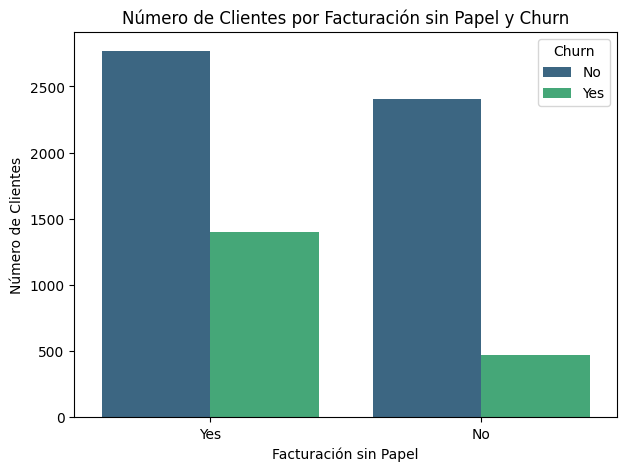


Porcentaje de Churn por Facturación sin Papel:
Churn                        No    Yes
account.PaperlessBilling              
No                        83.67  16.33
Yes                       66.43  33.57


In [24]:
print("\n--- Análisis de account.PaperlessBilling ---")
print("Distribución de facturación sin papel:")
print(df_telecom_normalizado['account.PaperlessBilling'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(data=df_telecom_normalizado, x='account.PaperlessBilling', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Facturación sin Papel y Churn')
plt.xlabel('Facturación sin Papel')
plt.ylabel('Número de Clientes')
plt.show()

# Porcentaje de Churn por PaperlessBilling
churn_paperless = df_telecom_normalizado.groupby('account.PaperlessBilling')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Facturación sin Papel:")
print(churn_paperless.round(2))

## customer.Partner y customer.Dependents (Familia)
**Explicación**: Indican si el cliente vive con una pareja o tiene dependientes. Los hogares con múltiples personas (y, por lo tanto, múltiples usuarios del servicio) pueden ser más estables y menos propensos al churn debido a la complejidad de cambiar de proveedor.

**Tipo de Dato**: Categórico (Yes/No).

**Tratamiento**: Codificación One-Hot Encoding.

**Gráfico**: Barras con hue='Churn' para cada una.


--- Análisis de customer.Partner ---
Distribución de clientes con/sin pareja:
customer.Partner
No     3641
Yes    3402
Name: count, dtype: int64


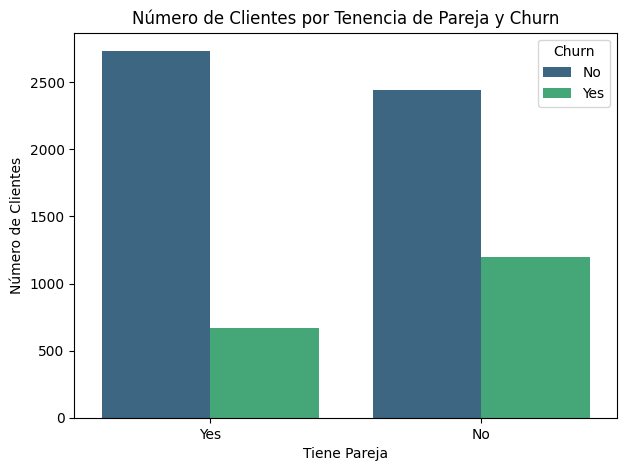


Porcentaje de Churn por Tenencia de Pareja:
Churn                No    Yes
customer.Partner              
No                67.04  32.96
Yes               80.34  19.66

--- Análisis de customer.Dependents ---
Distribución de clientes con/sin dependientes:
customer.Dependents
No     4933
Yes    2110
Name: count, dtype: int64


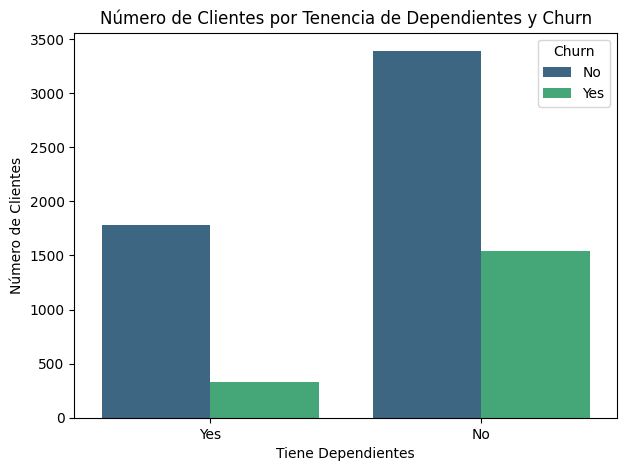


Porcentaje de Churn por Tenencia de Dependientes:
Churn                   No    Yes
customer.Dependents              
No                   68.72  31.28
Yes                  84.55  15.45


In [25]:
print("\n--- Análisis de customer.Partner ---")
print("Distribución de clientes con/sin pareja:")
print(df_telecom_normalizado['customer.Partner'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(data=df_telecom_normalizado, x='customer.Partner', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Tenencia de Pareja y Churn')
plt.xlabel('Tiene Pareja')
plt.ylabel('Número de Clientes')
plt.show()

# Porcentaje de Churn por Partner
churn_partner = df_telecom_normalizado.groupby('customer.Partner')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Tenencia de Pareja:")
print(churn_partner.round(2))

print("\n--- Análisis de customer.Dependents ---")
print("Distribución de clientes con/sin dependientes:")
print(df_telecom_normalizado['customer.Dependents'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(data=df_telecom_normalizado, x='customer.Dependents', hue='Churn', palette='viridis')
plt.title('Número de Clientes por Tenencia de Dependientes y Churn')
plt.xlabel('Tiene Dependientes')
plt.ylabel('Número de Clientes')
plt.show()

# Porcentaje de Churn por Dependents
churn_dependents = df_telecom_normalizado.groupby('customer.Dependents')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\nPorcentaje de Churn por Tenencia de Dependientes:")
print(churn_dependents.round(2))

In [26]:
# Crear una nueva columna con los rangos
df_telecom_normalizado['tenure_group'] = pd.cut(
    df_telecom_normalizado['customer.tenure'],
    bins=[-1, 12, 24, 72],  # Rangos: 0-12, 13-24, 25+
    labels=['0-12 meses', '13-24 meses', '25+ meses']
)


In [27]:
# Agrupar por rango de antigüedad y calcular porcentaje de cancelación
churn_por_grupo = df_telecom_normalizado.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack()

# Multiplicamos por 100 para tener porcentajes
churn_por_grupo = churn_por_grupo * 100

# Mostrar resultados redondeados
print(churn_por_grupo.round(2))


Churn            No    Yes
tenure_group              
0-12 meses    52.56  47.44
13-24 meses   71.29  28.71
25+ meses     85.96  14.04


/tmp/ipython-input-27-3556520093.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [28]:
#Agrupar por tenure y churn
df_grouped = df_telecom_normalizado.groupby(['customer.tenure', 'Churn']).size().unstack(fill_value=0)

#Calcular el % de Churn por tenure
df_grouped['churn_rate'] = (df_grouped.get('Yes', 0) / df_grouped.sum(axis=1)) * 100

#Mostrar el resultado
print(df_grouped[['churn_rate']])


Churn            churn_rate
customer.tenure            
0                  0.000000
1                 61.990212
2                 51.680672
3                 47.000000
4                 47.159091
...                     ...
68                 9.000000
69                 8.421053
70                 9.243697
71                 3.529412
72                 1.657459

[73 rows x 1 columns]


/tmp/ipython-input-28-404019340.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Columna de cuentas diarias


--- Creación de la columna 'Cuentas_Diarias' ---
Columna 'Cuentas_Diarias' creada exitosamente usando 30.44 días por mes.
Primeras filas con la nueva columna:
   customerID  account.Charges.Monthly  Cuentas_Diarias
0  0002-ORFBO                     65.6         2.155059
1  0003-MKNFE                     59.9         1.967806
2  0004-TLHLJ                     73.9         2.427727
3  0011-IGKFF                     98.0         3.219448
4  0013-EXCHZ                     83.9         2.756242

Estadísticas descriptivas de 'Cuentas_Diarias':
count    7043.000000
mean        2.127519
std         0.988504
min         0.599540
25%         1.166229
50%         2.311104
75%         2.951708
max         3.901117
Name: Cuentas_Diarias, dtype: float64

--- Visualización de 'Cuentas_Diarias' vs Churn ---


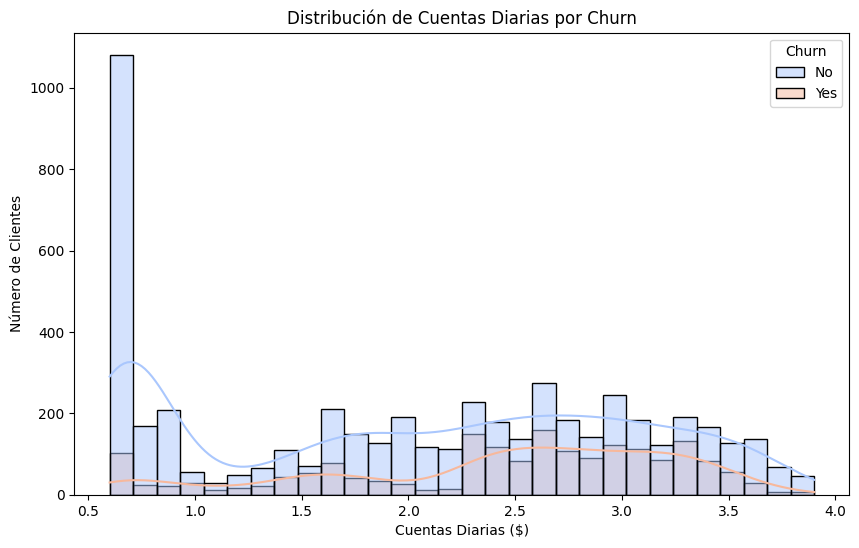

/tmp/ipython-input-29-3854351118.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




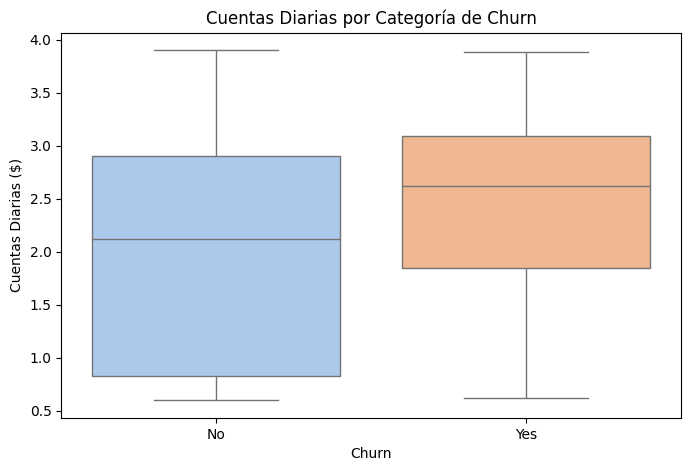

In [29]:
print("\n--- Creación de la columna 'Cuentas_Diarias' ---")

# Definimos el número promedio de días en un mes
dias_en_mes = 30.44

# Calculamos la nueva columna "Cuentas_Diarias"
# Aseguramos que 'account.Charges.Monthly' sea numérico para la división
df_telecom_normalizado['Cuentas_Diarias'] = df_telecom_normalizado['account.Charges.Monthly'].astype(float) / dias_en_mes

print(f"Columna 'Cuentas_Diarias' creada exitosamente usando {dias_en_mes} días por mes.")
print("Primeras filas con la nueva columna:")
print(df_telecom_normalizado[['customerID', 'account.Charges.Monthly', 'Cuentas_Diarias']].head())

print("\nEstadísticas descriptivas de 'Cuentas_Diarias':")
print(df_telecom_normalizado['Cuentas_Diarias'].describe())

# --- Visualización de la nueva columna ---
print("\n--- Visualización de 'Cuentas_Diarias' vs Churn ---")

# Histograma de Cuentas_Diarias por Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_telecom_normalizado, x='Cuentas_Diarias', bins=30, kde=True, hue='Churn', palette='coolwarm')
plt.title('Distribución de Cuentas Diarias por Churn')
plt.xlabel('Cuentas Diarias ($)')
plt.ylabel('Número de Clientes')
plt.show()

# Boxplot de Cuentas_Diarias vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_telecom_normalizado, x='Churn', y='Cuentas_Diarias', palette='pastel')
plt.title('Cuentas Diarias por Categoría de Churn')
plt.xlabel('Churn')
plt.ylabel('Cuentas Diarias ($)')
plt.show()

# Scatter plot con Tenure y Cuentas_Diarias
fig = px.scatter(df_telecom_normalizado,
                 x='customer.tenure',
                 y='Cuentas_Diarias',
                 color='Churn',
                 title='Relación entre Antigüedad, Cuentas Diarias y Churn',
                 labels={'customer.tenure': 'Antigüedad (Meses)', 'Cuentas_Diarias': 'Cuentas Diarias ($)'})
fig.show()

#📄Informe final: Análisis de Evasión (Churn) de Clientes en TelecomX

##🔹 **Introducción: El Problema del Churn**
En el sector de las telecomunicaciones, la evasión de clientes (Churn) representa uno de los mayores desafíos para las empresas como TelecomX (Telecentro). El churn se refiere a los clientes que deciden finalizar su relación contractual con un proveedor de servicios. Una alta tasa de churn puede impactar significativamente los ingresos, la rentabilidad y el crecimiento de la empresa, ya que es más costoso adquirir un nuevo cliente que retener uno existente.

El objetivo de este análisis ha sido comprender los factores clave que influyen en la decisión de los clientes de TelecomX de darse de baja, utilizando un enfoque basado en datos. A través de la exploración y visualización de un conjunto de datos representativo, buscamos identificar patrones y características comunes entre los clientes que abandonan, con el fin de proporcionar información estratégica que ayude a reducir esta evasión.

##🔹 **Limpieza y Tratamiento de Datos**
El proceso de preparación de los datos es fundamental para garantizar la calidad y fiabilidad de cualquier análisis. Se siguieron los siguientes pasos:

###**1. Extracción de Datos**: Los datos se obtuvieron de una fuente JSON remota (https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json) utilizando la librería requests y se cargaron en un DataFrame de Pandas.


###**2. Normalización de JSON Anidado**: El archivo JSON presentaba una estructura anidada con secciones como customer, phone, internet y account. Se utilizó pd.json_normalize() para aplanar esta estructura, creando un DataFrame plano donde las columnas anidadas fueron prefijadas (customer.gender, account.Contract, etc.), facilitando su manipulación.

### **3. Manejo de Valores Nulos y Vacíos**:

* Se identificó que la columna account.Charges.Total contenía valores no numéricos (cadenas vacías) que impedían su uso correcto. Estos fueron convertidos a numéricos (pd.to_numeric) y los valores resultantes NaN (debido a los espacios en blanco) fueron imputados con 0, asumiendo que representan cargos nulos para clientes nuevos. Finalmente, la columna se convirtió a tipo float64.

* Se detectaron y eliminaron filas donde la variable objetivo Churn estaba vacía, asegurando que el análisis de churn se basara solo en datos completos y válidos.

* Se verificó la ausencia de valores nulos o cadenas vacías en el resto del DataFrame.


###**4. Detección y Eliminación de Duplicados**: Se comprobó la existencia de filas completamente duplicadas y se eliminaron para evitar sesgos en el análisis.

###**5. Ajuste de Tipos de Datos**: Columnas como Churn se convirtieron al tipo category para optimizar el uso de memoria y preparar la columna objetivo para el modelado.

### **6. Ingeniería de Características - Creación de Cuentas_Diarias**: Se generó una nueva característica (Cuentas_Diarias) a partir de account.Charges.Monthly, dividiendo el cargo mensual por el número promedio de días en un mes (30.44). Esta variable proporciona una granularidad más fina del gasto del cliente y puede revelar patrones de churn a una escala diaria.

##🔹 **Análisis Exploratorio de Datos (EDA)**
El EDA se centró en identificar patrones y relaciones entre las variables del dataset y la variable Churn. Las visualizaciones fueron clave para obtener insights.

### **1. Distribución de la Variable Objetivo (Churn)**
Se observó el balance entre clientes que se dan de baja (Yes) y los que permanecen (No).

**Insight**: El porcentaje de churn es aproximadamente del 26.54% de la base de clientes. Esto indica un problema de desbalance de clases, lo cual es común en los problemas de churn y deberá ser considerado en la fase de modelado.

### **2. Conteo de Evasión por Variables Numéricas**


####**customer.tenure (Antigüedad del Cliente)**:

* **Análisis**: Los histogramas y boxplots mostraron una clara relación inversa: los clientes con baja antigüedad (pocos meses) tienen una tasa de churn significativamente más alta. La tasa de churn es muy elevada en los primeros meses (especialmente el primer mes) y disminuye drásticamente a medida que la antigüedad aumenta, estabilizándose para clientes con más de 24 meses.

* **Insight**: La "luna de miel" es crítica. Los clientes nuevos son más volátiles.

#### **account.Charges.Monthly (Cargo Mensual)**:
* **Análisis**: Los clientes que hacen churn tienden a tener cargos mensuales promedio más altos en comparación con los que no hacen churn. Los boxplots revelaron que la mediana de los cargos mensuales es superior para el grupo de Churn = Yes.

* **Insight**: La sensibilidad al precio o la percepción de bajo valor por un servicio costoso podría ser un factor.



####**Cuentas_Diarias (Cargo Diario Calculado)**:


* **Análisis**: Similar a account.Charges.Monthly, la distribución de Cuentas_Diarias también mostró que los clientes que se van tienden a tener un gasto diario más elevado.

* **Insight**: Refuerza la idea de que el costo puede ser un impulsor de churn, incluso en una escala diaria.




### **3. Conteo de Evasión por Variables Categóricas**

#### **account.Contract (Tipo de Contrato)**:


* **Análisis**: Esta es una de las variables más influyentes. Los clientes con contratos "Month-to-month" (mes a mes) tienen una tasa de churn extremadamente alta (alrededor del 42%). En contraste, los contratos de "One year" y "Two year" tienen tasas de churn significativamente bajas (alrededor del 11% y 3% respectivamente).

* **Insight**: La existencia de un contrato a largo plazo es un fuerte indicador de lealtad y reduce drásticamente el riesgo de churn.




#### **internet.InternetService (Tipo de Servicio de Internet)**:
* **Análisis**: Los clientes con "Fiber optic" (Fibra Óptica) muestran una tasa de churn considerablemente más alta (alrededor del 42%) en comparación con "DSL" (aproximadamente 19%) o "No" servicio de internet (aproximadamente 7%).

* **Insight**: A pesar de ser una tecnología más avanzada, la Fibra Óptica podría estar asociada a mayores expectativas, problemas técnicos no resueltos o precios percibidos como altos.

#### **internet.TechSupport (Soporte Técnico)**:
* **Análisis**: Los clientes que NO tienen soporte técnico ("No") o que no tienen servicio de internet ("No internet service") presentan una tasa de churn más alta que aquellos que sí tienen soporte técnico.

* **Insight**: El soporte técnico es un "pegamento" importante. Los clientes sin él, especialmente si enfrentan problemas, tienen mayor probabilidad de irse.

#### **account.PaymentMethod (Método de Pago)**:
* **Análisis**: El método de pago "Electronic check" (Cheque electrónico) está fuertemente asociado con una tasa de churn mucho más elevada (alrededor del 45%) en comparación con otros métodos como "Mailed check", "Bank transfer (automatic)" o "Credit card (automatic)".

* **Insight**: Los clientes que usan cheque electrónico podrían ser más propensos a una menor lealtad o buscan mayor flexibilidad, mientras que los métodos automáticos sugieren mayor arraigo.

#### **account.PaperlessBilling (Facturación sin Papel)**:
* **Análisis**: Los clientes con facturación sin papel ("Yes") muestran una tasa de churn más alta (alrededor del 33%) que aquellos con facturación en papel ("No", aproximadamente 16%).

* **Insight**: Podría indicar que los clientes digitalmente más activos son también más propensos a buscar alternativas en línea y cambiar de proveedor.

#### **customer.Partner y customer.Dependents (Pareja y Dependientes)**:
* **Análisis**: Los clientes sin pareja ("No") y sin dependientes ("No") tienen una tasa de churn más alta que aquellos con pareja o dependientes.

* **Insight**: Los hogares con múltiples usuarios o responsabilidades familiares tienden a ser más estables y menos propensos a cambiar de proveedor de servicios debido a la complejidad que esto implica.

#### **customer.gender (Género) y customer.SeniorCitizen (Adulto Mayor)**:
* **Análisis**: La variable gender mostró poca o ninguna diferencia en la tasa de churn. Para SeniorCitizen, los adultos mayores (SeniorCitizen=1) tienen una tasa de churn ligeramente más alta que los no-adultos mayores.

* **Insight**: El género no parece ser un factor diferenciador para el churn en este dataset. Los adultos mayores podrían tener necesidades o problemas de uso específicos.

## 🔹 **Conclusiones e Insights Clave**
El análisis exploratorio de datos ha revelado varios factores críticos que influyen en la evasión de clientes en TelecomX:

* **El compromiso es clave**: La antigüedad del cliente y el tipo de contrato son los predictores más potentes. Clientes nuevos y aquellos con contratos mes a mes son los de mayor riesgo.

* **Servicios y Calidad**: El tipo de servicio de internet (Fibra Óptica) y la ausencia de soporte técnico están asociados con tasas de churn elevadas. Esto sugiere posibles problemas de satisfacción o manejo de expectativas con los servicios de alta gama o la necesidad crítica de un soporte efectivo.

* **Métodos de Pago y Comportamiento Digital**: El uso de cheques electrónicos y la facturación sin papel se correlacionan con un mayor churn, lo que podría indicar un perfil de cliente más "desapegado" o más propenso a la búsqueda de mejores ofertas en línea.

* **Estabilidad del Hogar**: Los clientes sin pareja o sin dependientes muestran una mayor propensión al churn, lo que sugiere que la estabilidad del hogar y la necesidad de un servicio compartido actúan como factores de retención.

* **Costo Percibido**: Aunque no es el único factor, un cargo mensual más alto está presente en el perfil de los clientes que se van, lo que podría indicar sensibilidad al precio o una percepción de bajo valor.

## 🔹 **Recomendaciones Estratégicas**
Basadas en estos hallazgos, se proponen las siguientes recomendaciones para TelecomX con el objetivo de reducir la evasión de clientes:

### **1. Programas de Retención para Clientes Nuevos**:
* **Acción**: Implementar campañas de seguimiento proactivo y personalizado durante los primeros 3-6 meses de servicio, ofreciendo soporte adicional, tutoriales de uso o beneficios especiales.

* **Justificación**: La alta tasa de churn en clientes de baja antigüedad demuestra que los primeros meses son críticos para establecer la lealtad.

### **2. Incentivar Contratos a Largo Plazo**:
* **Acción**: Crear ofertas atractivas o descuentos significativos para los clientes con contratos mes a mes que transicionen a contratos de uno o dos años.

* **Justificación**: Los contratos a largo plazo son el "pegamento" más fuerte contra el churn.

### **3. Mejorar la Experiencia con Fibra Óptica y Reforzar el Soporte Técnico**:
* **Acción**: Investigar a fondo las causas de churn en el servicio de Fibra Óptica (problemas de instalación, rendimiento, atención al cliente). Promocionar activamente los beneficios del soporte técnico y quizás integrarlo por defecto en ciertos planes.

* **Justificación**: La insatisfacción con el servicio principal y la falta de apoyo técnico son detonantes de churn.

### **4. Análisis y Gestión de Métodos de Pago**:

* **Acción**: Estudiar el comportamiento de los clientes que utilizan "cheque electrónico". Podría ser útil ofrecer incentivos para que cambien a métodos de pago automáticos, o diseñar estrategias de retención específicas para este segmento de clientes.

* **Justificación**: Este método de pago es un indicador de mayor riesgo.

### **5. Segmentación y Ofertas Personalizadas**:

* **Acción**: Utilizar las variables demográficas (pareja, dependientes, adulto mayor) para segmentar a los clientes y crear campañas de retención más dirigidas que aborden las necesidades específicas de cada grupo. Por ejemplo, planes familiares o soporte técnico especializado para adultos mayores.

* **Justificación**: Entender el perfil del hogar ayuda a crear ofertas de mayor "valor percibido".

### **6. Reevaluación de Precios y Valor**:

* **Acción**: Analizar si los planes con cargos mensuales más altos están ofreciendo el valor percibido adecuado. Realizar encuestas de satisfacción para entender si los clientes sienten que están pagando demasiado por lo que reciben.

* **Justificación**: El costo, aunque no el único, es un factor de sensibilidad para los clientes